In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.patches import FancyArrowPatch
import matplotlib.patches as patches
from scipy.integrate import solve_ivp
from scipy.interpolate import CubicSpline

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

### Boat Problem: Simple Case

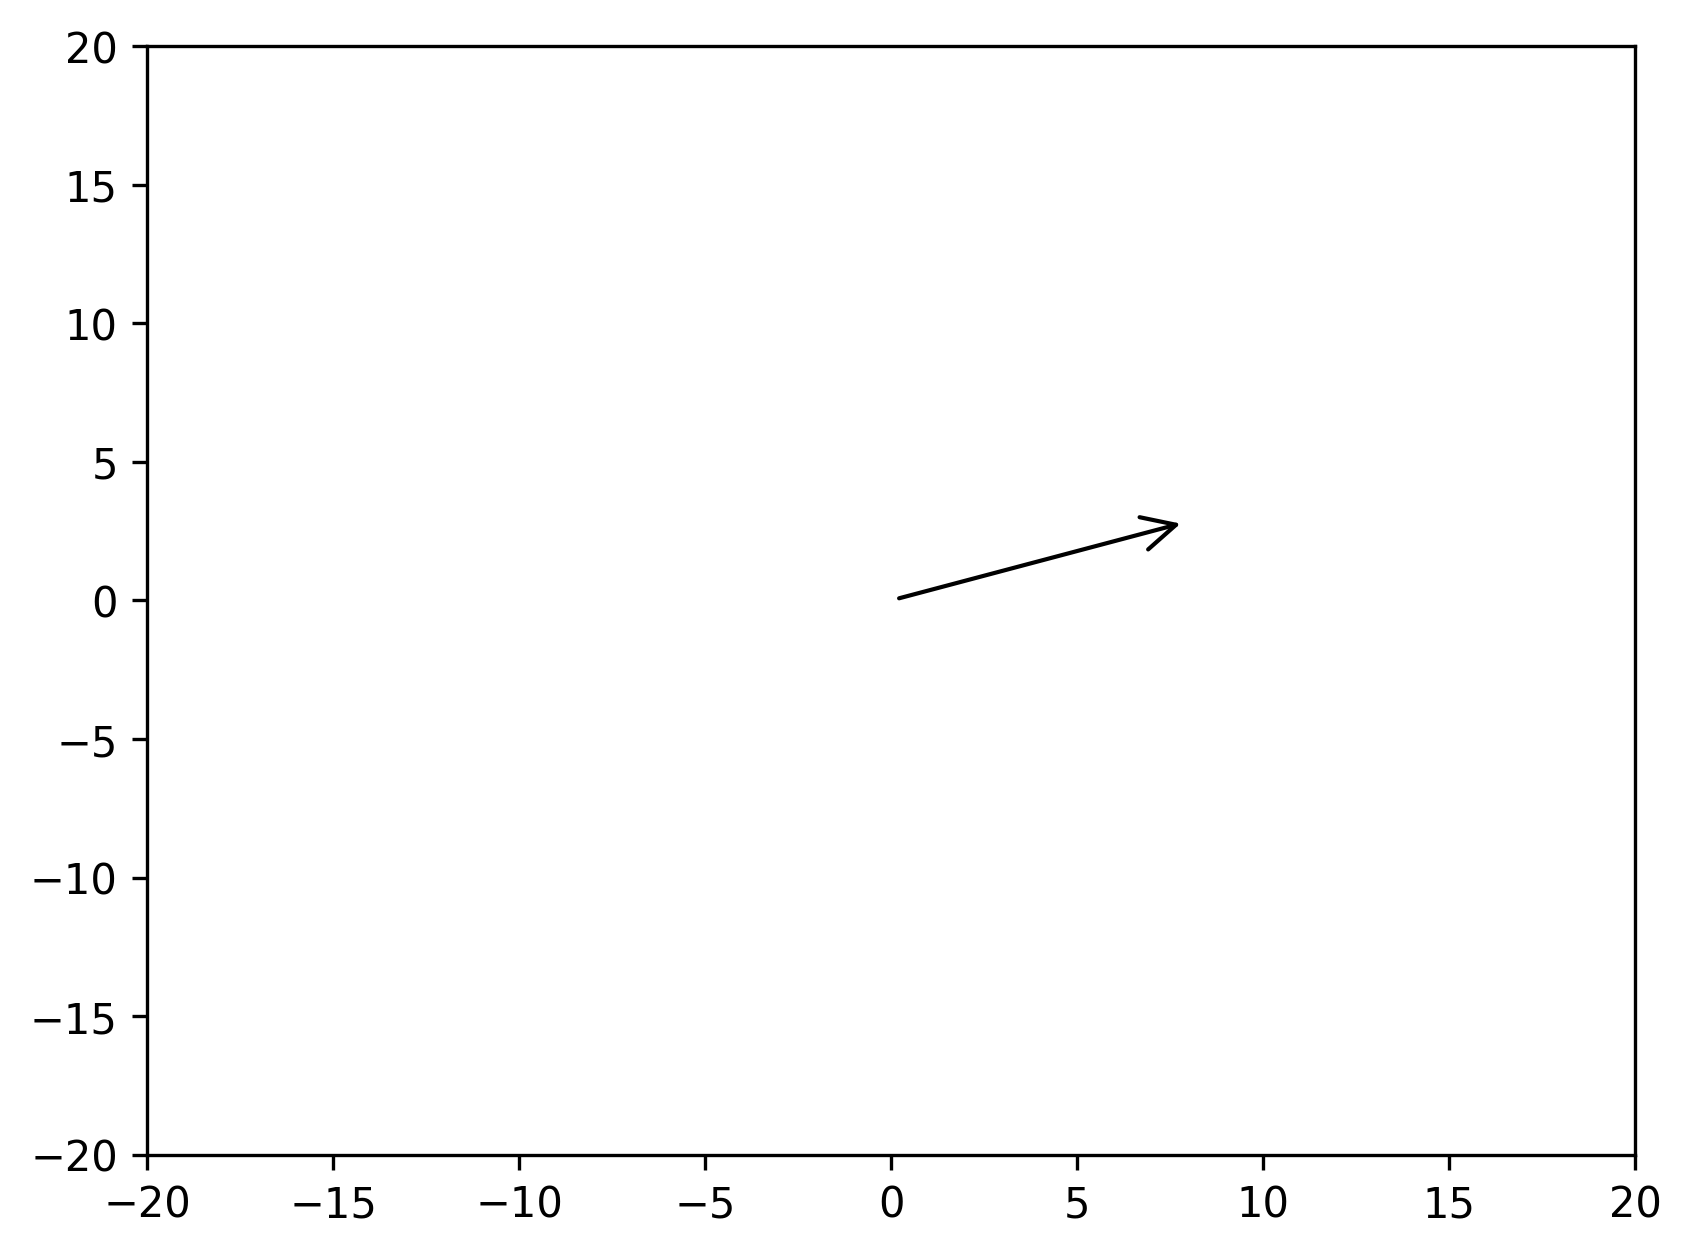

In [3]:
### Wind function ###
tf = 100
t = np.linspace(0, tf, 100)

# Constant wind
av_speed = 8
constant_wind = lambda t: av_speed*np.ones_like(t)
constant_x_wind = constant_wind(t)

# Variable wind
amplitude = 4
frequency = 0.2
wind_func = lambda t: av_speed + amplitude * np.sin(frequency * t)
variable_x_wind = wind_func(t)
variable_y_wind = constant_wind(t) * np.random.random(size=len(t))

# Plot wind over time
fig, ax = plt.subplots()

ax.set_xlim(-20, 20)
ax.set_ylim(-20, 20)

# Initialize vec
wind_vec = FancyArrowPatch((0, 0), (0, 0), arrowstyle='->', mutation_scale=20)
ax.add_patch(wind_vec)

def animation_function(t):
    x = variable_x_wind[t]
    y = variable_y_wind[t]

    wind_vec.set_positions((0, 0), (x, y))
    return wind_vec
    
animation = FuncAnimation(fig, func=animation_function, frames=np.arange(len(t)), interval=tf)
animation.save("wind.mp4")

<video src="wind.mp4" controls>

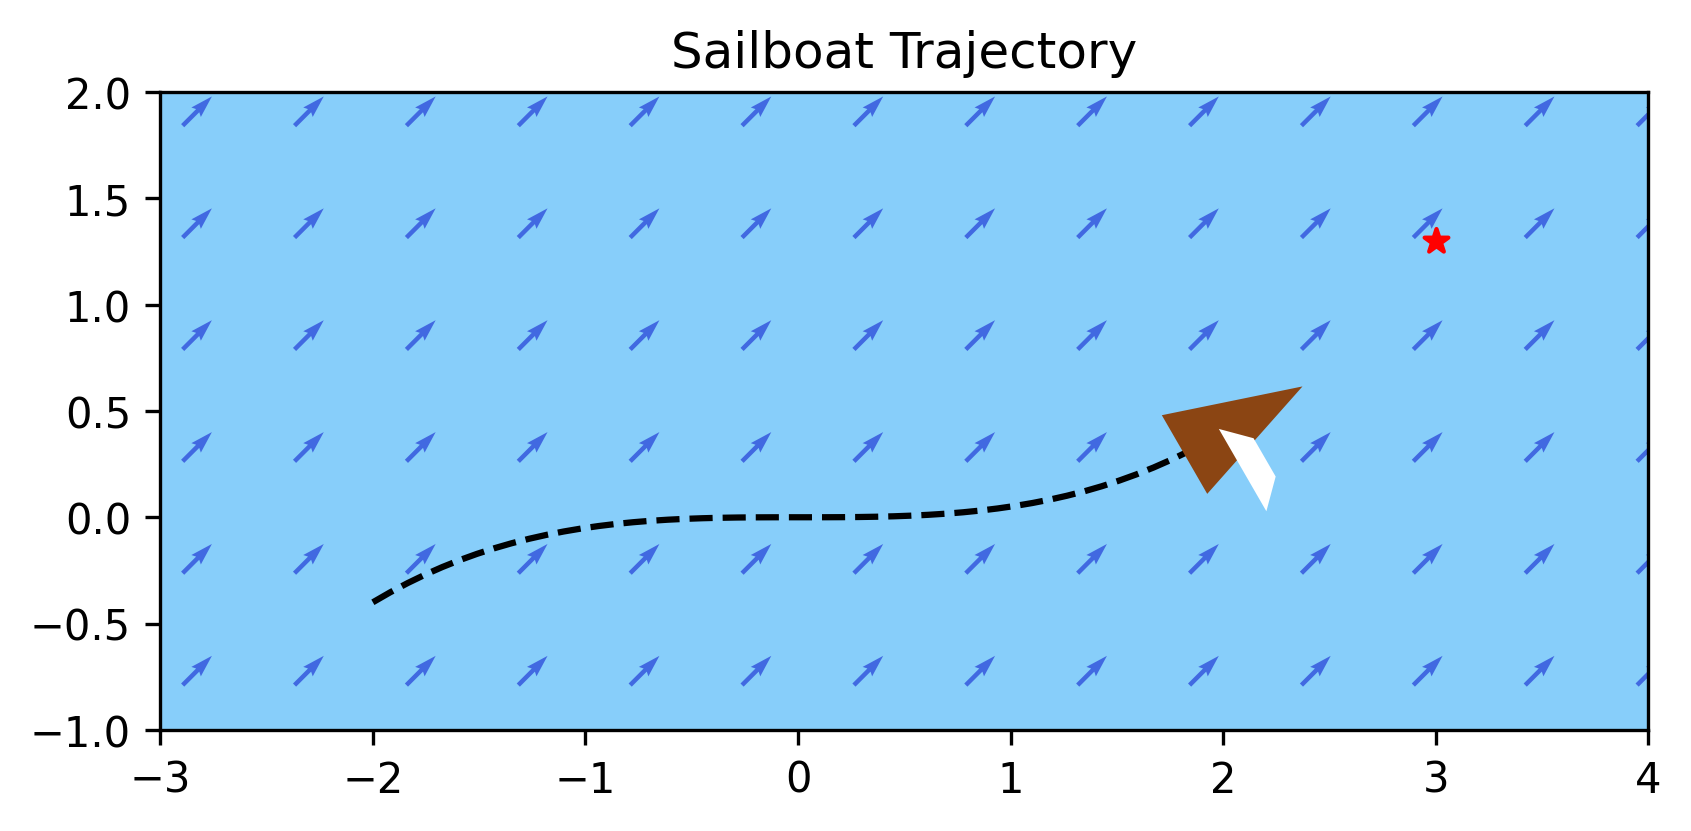

In [64]:
### Plot boat in the water ###

# Made-up Trajectory
x = np.linspace(-2, 2)
y = 0.05 * x**3

def create_boat(center=(0, 0), size=1.0, phi=0, theta=0):
    """Make a little triangle that looks like a boat. Also make a little sail"""
    theta = -theta
    # theta = theta%(2*np.pi)
    # Get vertices relative to origin (boat starts facing right)
    triangle = np.array([
        [2, 0], # Right vertex
        [-1, 1], # Bottom left
        [-1, -1] # Bottom right
    ]) * size

    if theta < 0 and theta >= -np.pi:
        sail = np.array([
            [0, 0],
            [-0.5, 0.5],
            [-1.5, 0.5],
            [-2, 0]
        ]) * size
    else:
        sail = np.array([
            [0, 0],
            [-0.5, -0.5],
            [-1.5, -0.5],
            [-2, 0]
        ]) * size

    # Rotation matrix
    rotation_matrix = lambda angle: np.array([
        [np.cos(angle), -np.sin(angle)],
        [np.sin(angle), np.cos(angle)]
    ])

    # Rotate and translate
    rotated_boat = rotation_matrix(phi) @ triangle.T
    translated_boat = rotated_boat.T + np.array(center)
    rotated_sail = rotation_matrix(phi + theta) @ sail.T
    translated_sail = rotated_sail.T + np.array(center)
    
    return translated_boat, translated_sail

# Plot
plt.title("Sailboat Trajectory")
ax = plt.gca()
ax.set_facecolor("lightskyblue") # background color
ax.plot(x, y, "k--", zorder=1) # plot trajectory

# Plot boat
triangle_coords, sail_coords = create_boat(center=(x[-1], y[-1]), size=0.2, phi=np.pi/6, theta=-np.pi/2)
triangle_patch = patches.Polygon(triangle_coords, closed=True, color="saddlebrown", zorder=2)
sail_patch = patches.Polygon(sail_coords, closed=True, color="white", zorder=3)
ax.add_patch(triangle_patch)
ax.add_patch(sail_patch)

# Plot target
ax.scatter(3, 1.3, marker="*", c="r")

# Plot wind vector field
x, y = np.meshgrid(np.linspace(-5, 5, 20), np.linspace(-5, 5, 20))
u = 0.25 * np.ones_like(x) # x component of wind
v = 0.25 * np.ones_like(y) # y component of wind
plt.quiver(x, y, u, v, color="royalblue", zorder=1)

ax.set_xlim(-3, 4)
ax.set_ylim(-1, 2)
plt.gca().set_aspect('equal')
plt.show()

## Coding up the 1D optimal theta

In [55]:

### Wind function ###
tf = 100
t = np.linspace(0, tf, 100)
t_span = (0, tf)

# Constant wind
av_speed = .2
constant_wind = lambda t: av_speed*np.ones_like(t)
constant_x_wind = constant_wind(t)

# Variable wind
amplitude = .1
frequency = 0.02
wind_funcx = lambda t: av_speed + amplitude * np.sin(frequency * t)
wind_funcy = lambda t: constant_wind(t) * np.random.random(size=1)
# wind_funcx = lambda t: 2.0
# wind_funcy = lambda t: .5
variable_x_wind = wind_func(t)
variable_y_wind = constant_wind(t) * np.random.random(size=1)



mu = .98
optimal_theta = lambda wx,wy: (np.arctan(wx/wy))
bad_theta = lambda wx,wy: 10*np.arctan(wx/wy)

def ode1(t,state):
    
    '''defining the optimal ode system'''
    x,y,vx,vy = state
    wx = wind_funcx(t)
    wy = wind_funcy(t)
    theta = optimal_theta(wx,wy)
    dx = 1
    dy = 0
    thing = wx*(np.sin(theta)**2)*dx +wx*np.sin(theta)*np.cos(theta)*dy + wy*np.cos(theta)*np.sin(theta)*dx + wy*(np.cos(theta)**2) * dx
    ax = thing*dx
    ay = thing*dy
    return np.array([vx - np.sign(vx)*mu*np.abs(vx),vy - vy*mu*np.abs(vy),ax[0],ay[0]])


def ode2(t,state):
    '''defining the sub_optimal ode system'''

    x,y,vx,vy = state
    wx = wind_funcx(t)
    wy = wind_funcy(t)
    theta = bad_theta(wx,wy)
    dx = 1
    dy = 0
    thing = wx*np.sin(theta)**2*dx +wx*np.sin(theta)*np.cos(theta)*dy + wy*np.cos(theta)*np.sin(theta)*dx + wy*np.cos(theta)**2 * dx
    ax = thing*dx
    ay = thing*dy
    return np.array([vx - np.sign(vx)*mu*np.abs(vx),vy - vy*mu*np.abs(vy),ax[0],ay[0]])


"Initial conditions"
y0 = np.array([0,0,0,0])
#Solving
sol1 = solve_ivp(ode1, t_span, y0, max_step = .01,dense_output = True)
sol2 = solve_ivp(ode2, t_span, y0, max_step = .01,dense_output = True)



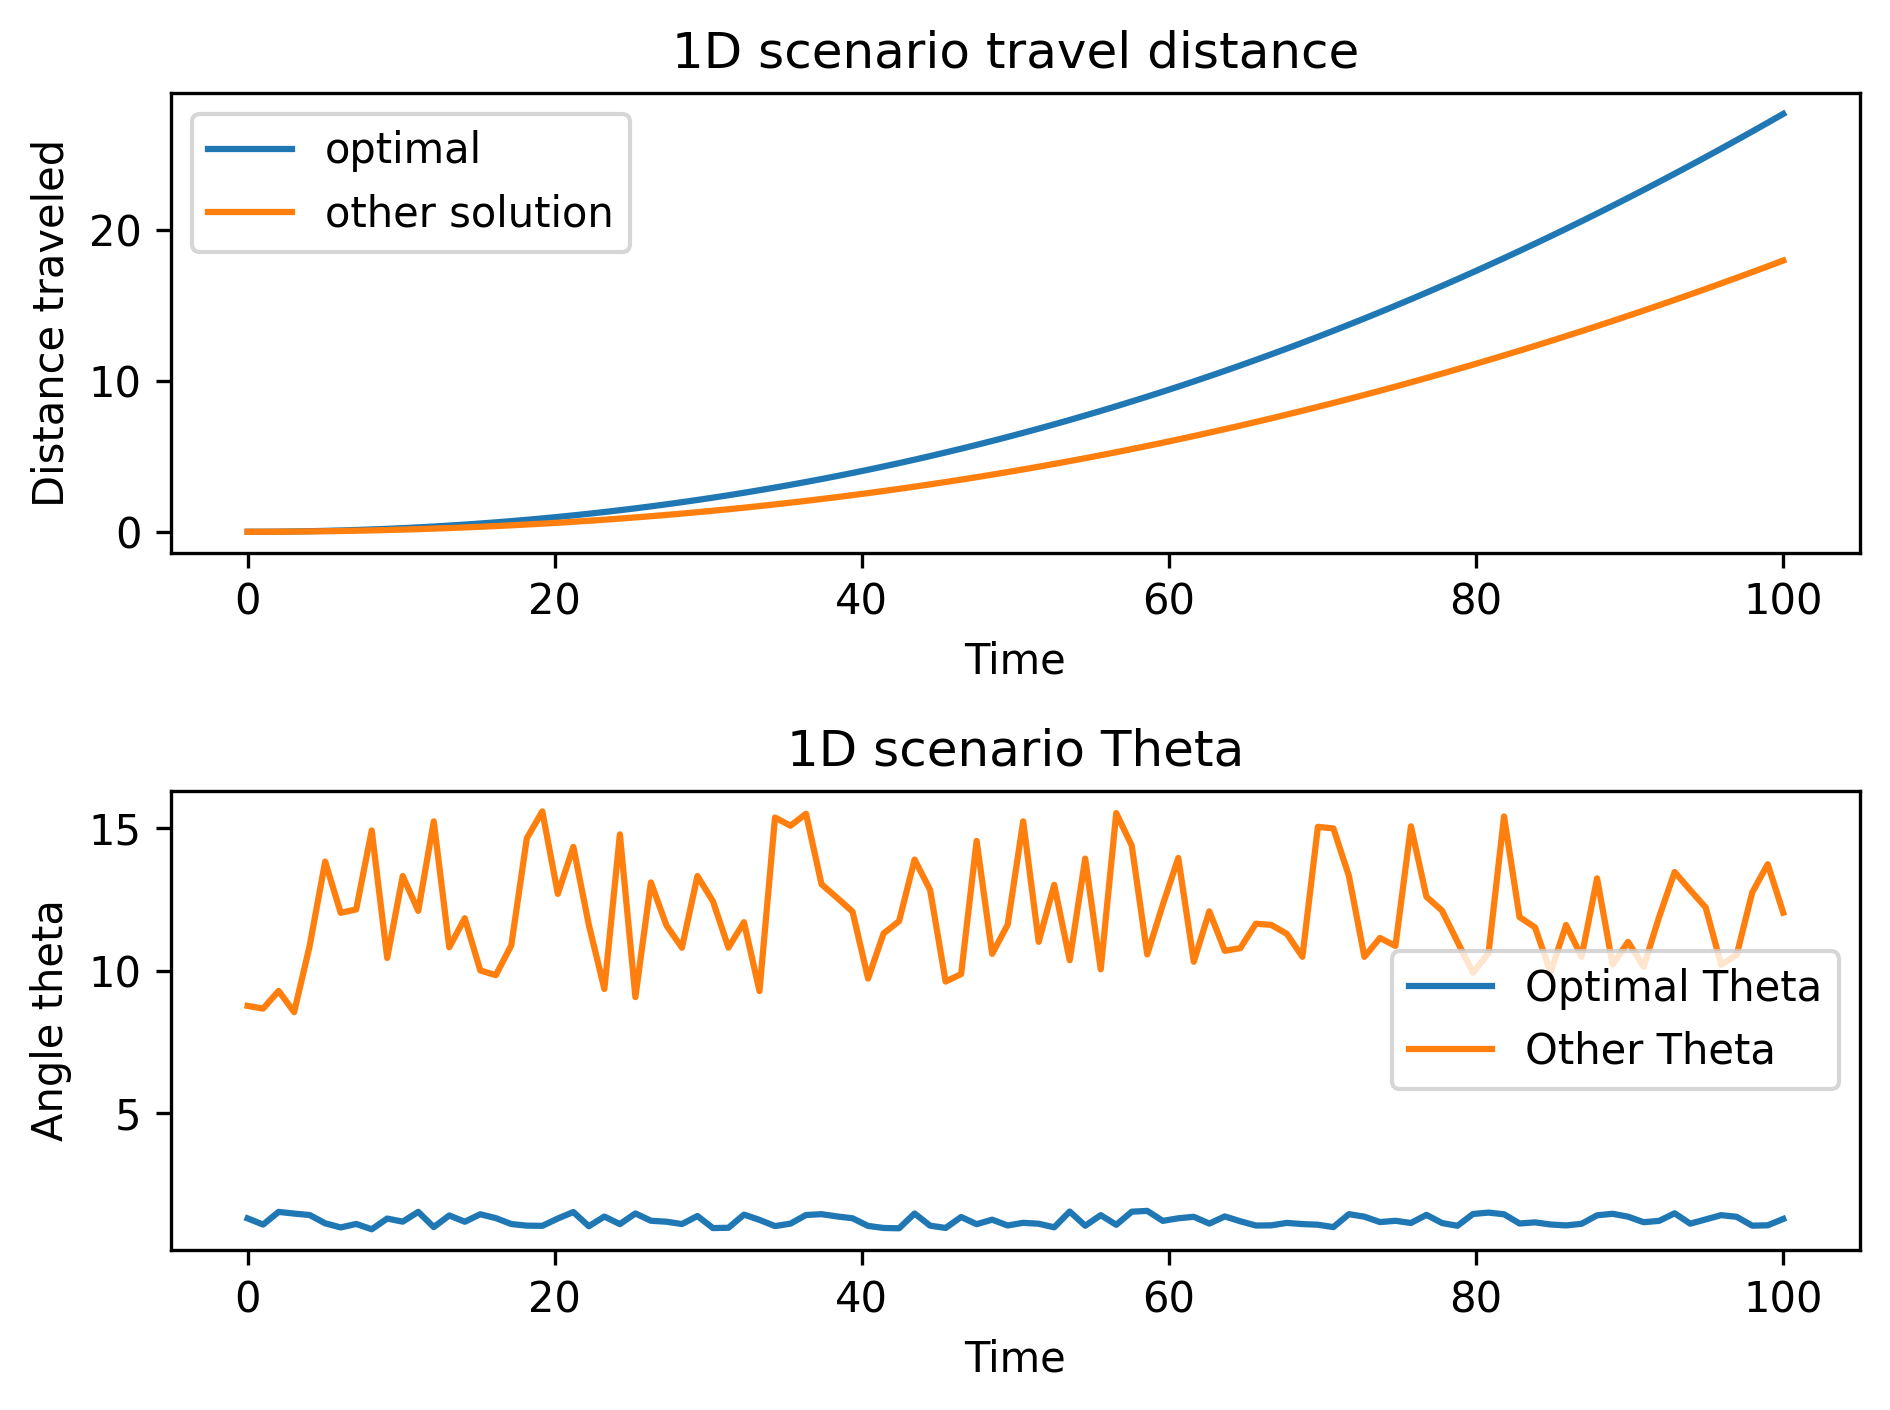

In [56]:
ts = np.linspace(0,100,100)
windx = wind_funcx(ts)
windy = wind_funcy(ts)
good_thetas = optimal_theta(windx,windy)
bad_thetas = bad_theta(windx,windy)

#Plotting Optimal
plt.subplot(2,1,1)
plt.plot(ts,sol1.sol(ts)[0], label = "optimal")
plt.plot(ts,sol2.sol(ts)[0], label = "other solution")
plt.legend()
plt.ylabel("Distance traveled")
plt.xlabel("Time")
plt.title("1D scenario travel distance")
plt.subplot(2,1,2)
plt.plot(ts, ([optimal_theta(wind_funcx(i),wind_funcy(i)) for i in ts]), label = "Optimal Theta")
plt.plot(ts, ([bad_theta(wind_funcx(i),wind_funcy(i)) for i in ts]), label = "Other Theta")
plt.ylabel("Angle theta")
plt.title("1D scenario Theta")
plt.xlabel("Time")
plt.legend()
plt.tight_layout()
plt.show()

Python(95603) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


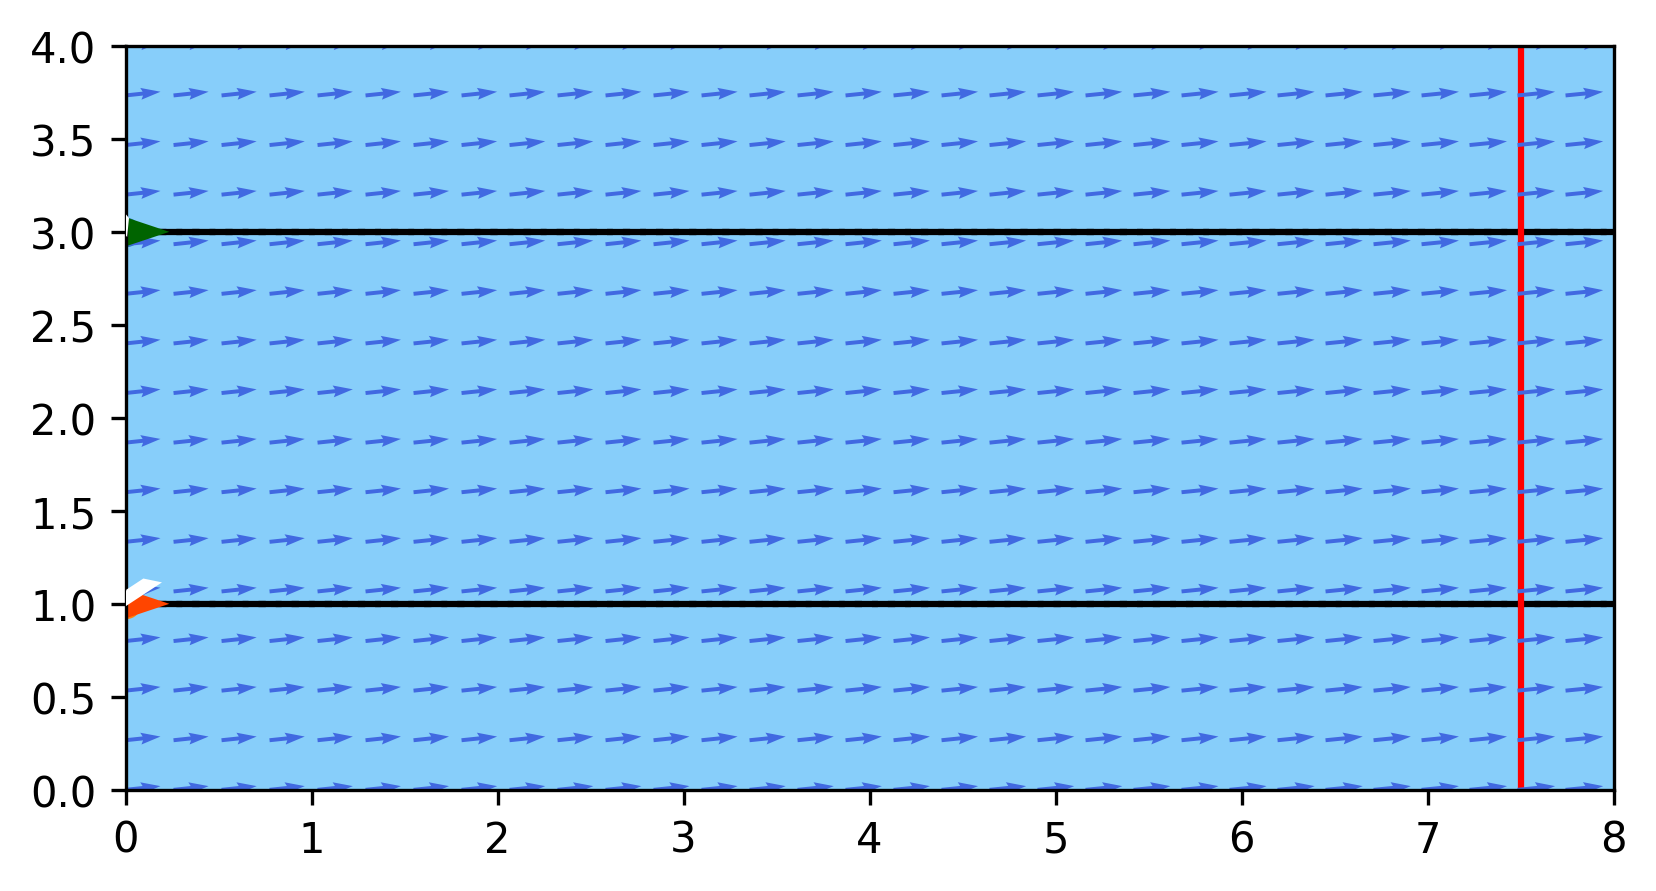

In [65]:
t = np.linspace(0, 70, 100)
#Initializing figure specs
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax = plt.gca()
#print(sol1.sol(0)[0])
#Defining function
opt_checkpoints = []
sub_opt_checkpoints = []
def update(t):
    ax.clear()
    ax.set_xlim([0,8])
    ax.set_ylim([0,4])
    opt_checkpoints.append(sol1.sol(t)[0])
    Opt_checkpoints = np.array(opt_checkpoints)
    sub_opt_checkpoints.append(sol2.sol(t)[0])
    # Plot
    ax.set_facecolor("lightskyblue") # background color
    ax.plot(opt_checkpoints, 3*np.ones_like(Opt_checkpoints), "k--", zorder=1) # plot trajectory
    ax.plot(sub_opt_checkpoints, 1*np.ones_like(Opt_checkpoints), "k--", zorder=1) # plot trajectory
    # Plot boat
    windx = wind_funcx(t)
    windy = wind_funcy(t)
    good_thetas = optimal_theta(windx,windy)
    bad_thetas = bad_theta(windx,windy)
    opt_triangle_coords, opt_sail_coords = create_boat(center=(opt_checkpoints[-1], 3), size=0.1, phi=0, theta=good_thetas[0])
    sub_triangle_coords, sub_sail_coords = create_boat(center=(sub_opt_checkpoints[-1], 1), size=0.1, phi=0, theta = bad_thetas[0])
    opt_triangle_patch = patches.Polygon(opt_triangle_coords, closed=True, color="darkgreen", zorder=2)
    sub_triangle_patch = patches.Polygon(sub_triangle_coords, closed=True, color="orangered", zorder=2)
    opt_sail_patch = patches.Polygon(opt_sail_coords, closed=True, color="white", zorder=3)
    sub_sail_patch = patches.Polygon(sub_sail_coords, closed=True, color="white", zorder=3)
    ax.add_patch(opt_triangle_patch)
    ax.add_patch(opt_sail_patch)
    ax.add_patch(sub_triangle_patch)
    ax.add_patch(sub_sail_patch)
    ax.scatter(sol1.sol(t)[0],3, label = "Optimal")
    ax.scatter(sol2.sol(t)[0],1, label = "Sub-optimal")
    #plot finish
    ax.plot([7.5,7.5],[0,7], zorder = 1, c="red")
    plt.gca().set_aspect('equal')

    #plot wind
    X,Y = np.meshgrid(np.linspace(0,8,32),np.linspace(0,4,16))
    u = wind_funcx(X)
    v = wind_funcy(Y)
    ax.quiver(X,Y,u,v, color = "royalblue",zorder = 1)







animation = FuncAnimation(fig, update, frames=t)
animation.save("race.mp4")

<video src="race.mp4" controls> 

### Code up single-state electricity production problem

This might not be perfect since this will likely ignore our battery.

In [ ]:
def state_equations(t, x, u_interpolation, renewable_function):
    """
    Parameters:
        t : float
            the time
        x : ndarray (1,)
            the total energy production at time t
        u_interpolation : CubicSpline
            the values of the control u_interpolation(t) = [u1(t), u2(t)]
    
    Returns:
        x_dot : ndarray (1,)
            the rate energy production rate at time t
    """
    u = u_interpolation(t)
    R = renewable_function(t)
    x_dot = R + u

    return np.array(x_dot)

In [ ]:
def costate_equations(t, x, u_interpolation, state_solution,renewable_function):
    '''
    Parameters
    ---------------
    t : float
        the time
    y : ndarray (2,)
        the lambda values at time t 
    u_interpolation : CubicSpline
                      the values of the control u_interpolation(t) = [u1(t), u2(t)]
    state_solution : result of solve_ivp on state_equations with
        dense_output=True, i.e., state_solution.sol(t) = [T(t), V(t)]
    constants : a_1, a_2, b_1, b_2, s_1, s_2, mu, k, g, c, B_1, B_2, A_1, A_2
    
    Returns
    --------------
    y_dot : ndarray (2,)
            the derivative of lambda at time t
    '''
    x = state_solution.sol(t)
    u  = u_interpolation(t)
    R = renewable_function(t)
    

    return [-1 + l1*(mu+k*V-u1) + l2*c*V, l1*(B_1*s_2/((B_1+V)**2) + k*T) - l2*((B_2*g*(1-u2)/(B_2+V)**2) - c*T)]

In [ ]:

# R function
renewable_function = lambda t: R * np.sin(t)
# Define other constants.
x0 = 1
demand = lambda t: 100*np.sin(t)+ 1000*np.cos(t)
t_f = 1

# Initialize state, costate, and u.
state0 = np.array([x0])
costate0 = np.zeros(2)

u = np.zeros(1008) #This is 1 week in 10 minute intervals

max_step = 0.5

epsilon = 0.001
test = epsilon + 1

tls = np.linspace(0, t_f, n)
while(test > epsilon):
    oldu = u.copy()
    # u_interpolation = CubicSpline(...)
    u_interpolation = CubicSpline(tls,oldu, axis =1)
    # Solve the state equations forward in time.
    # state_solution = solve_ivp(...)
    """Time domain"""
    t_span = (0,t_f)
    """Initial conditions"""
    '''Solving'''
    sol_state = solve_ivp(state_equations, t_span, state0,args = (u_interpolation, renewable_function),method="RK45",dense_output=True)

    # Solve the costate equations backward in time.
    """Time domain"""
    t_span = (t_f,0)
    """Initial conditions"""
    '''Solving'''
    #Solve backwards since only have endpoint conditions for costate
    sol_costate = solve_ivp(costate_equations, (t_f, 0), costate0, method="RK45", t_eval=tls[::-1], args=(u_interpolation, sol_state, renewable_function),dense_output=True, max_step=max_step)

    # Solve for u1 and u2.
    def newu(t):
        x = sol_state.sol(t)
        l1,l2 = sol_costate.sol(t)
        return np.array([np.clip(((1/(2*A_1))*(l1*T)),a_1, b_1),np.clip((-l2/(2*A_2))*(g*V/(B_2+V)),a_2,b_2)])
    # Update control u with u1 and u2.
    u[0],u[1] = newu(tls)
    #print(u)
    # Test for convergence
    test = abs(oldu - u).sum()

NameError: name 'n' is not defined